In [1]:
# QUESTION 1 : DATA IMPLEMENTATION

# I had troubles to first open the data in my work file because Python was unable to 
# verify the SSL certificate of this URL. That's why I wrote these lines.
# I have chosen to work with 'a9a' dataset.

import requests
from sklearn.datasets import load_svmlight_file
import io

url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a"
response = requests.get(url, verify=False)

with open("a9a", "wb") as f:
    f.write(response.content)

# Load the dataset
X, y = load_svmlight_file("a9a")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.csie.ntu.edu.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


The features matrix X has a (32561, 123) shape whereas the label y has a (32561,) shape.
It means that we are working with 32561 observations of a data composed of 123 features.
Thus, X is a 32561*123 matrix while y is a 32561*1 vector where y(i) = +1 or -1
Here, for the features data X, for i in {1,..., 123}, we denote Xi the i-th column of X because we aim to study the correlation between certain features (so the columns of X). Hence corr(Xi,Xj) = cov(Xi, Xj) / std(Xi)*std(Xj). We are going to compute these values.

Text(0, 0.5, 'Features (Xj)')

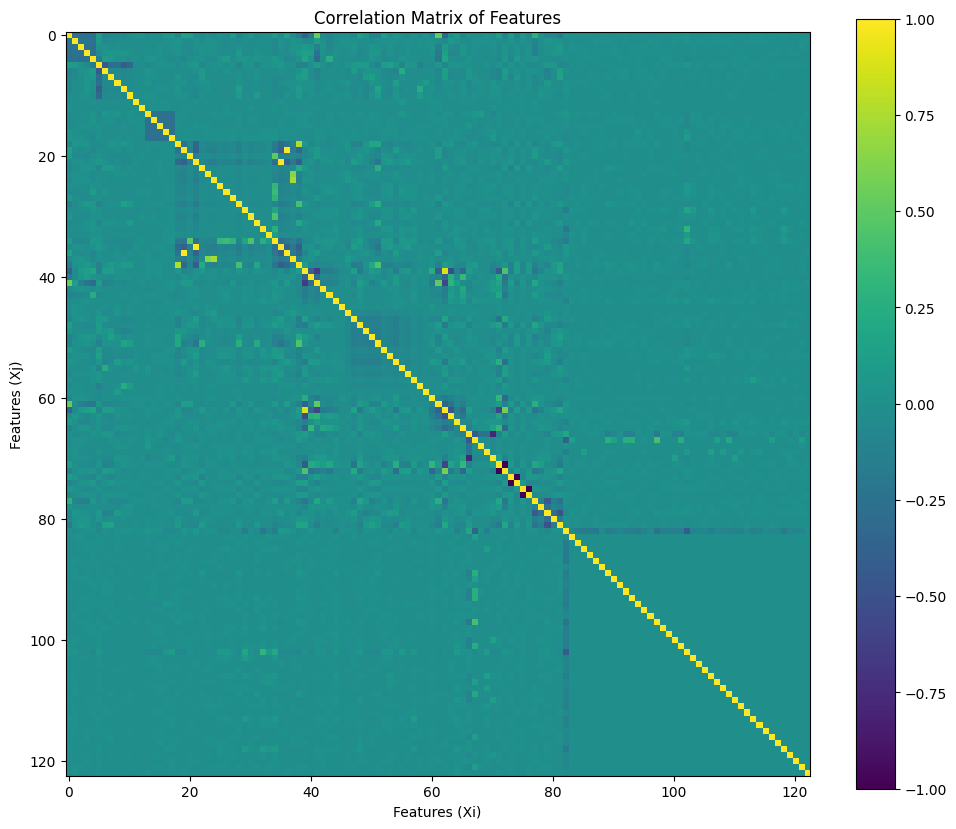

In [2]:
# QUESTION 1 : VISUALIZATION OF THE CORRELATION MATRIX

import numpy as np
import matplotlib.pyplot as plt

# We need a dense representation to work on the columns of X (rowvar=False) so we convert
X_dense = X.toarray()
correlation_matrix = np.corrcoef(X_dense, rowvar=False)

# The correlation matrix has a 123*123 size

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix)
plt.colorbar()
plt.title("Correlation Matrix of Features")
plt.xlabel("Features (Xi)")
plt.ylabel("Features (Xj)")


In [3]:
# QUESTION 2 : CODING OF THE GRADIENT IN TWO DIFFERENT WAYS

import autograd.numpy as np  
from autograd import grad 
from scipy.sparse import csr_matrix

# We first define the function fi which will be used with the data (ai, yi)

def f_i(x, a_i, y_i):
    produit_scalaire = np.dot(-a_i,x)
    quotient = 1 + np.exp(-produit_scalaire)
    return (y_i - 1/quotient)**2

gradient_i = grad(f_i, 0) # Derivative with respect to x (index 0 in the definition of f_i)

def theoretical_gradient_f_i_1(x, a_i, y_i):
    a_i = a_i.toarray().flatten() if isinstance(a_i, csr_matrix) else a_i # Help from CHATGPT to convert from row to dense 
    intermediate_term = np.exp(np.dot(a_i, x))*(y_i - 1) + y_i
    numerator = -2*np.exp(np.dot(a_i,x))*intermediate_term*a_i
    denominator = (1 + np.exp(np.dot(a_i, x)))**3
    return numerator/denominator

# Now that the gradient has been computed in two different ways, let's show the autograd implementation is correct
# We try to compute them on one example. 

x = np.array([2.0, 1.0, 1.0])  
a_i = np.array([1.0, 1.0, 1.0])  
y_i = 1  
autograd_gradient = gradient_i(x, a_i, y_i)
theoretical_gradient = theoretical_gradient_f_i_1(x, a_i, y_i)

print("Autograd Gradient:", autograd_gradient)
print("Theoretical Gradient:", theoretical_gradient)
print("Are the gradients approximately equal?", np.allclose(autograd_gradient, theoretical_gradient))


Autograd Gradient: [0.03469004 0.03469004 0.03469004]
Theoretical Gradient: [-0.00063537 -0.00063537 -0.00063537]
Are the gradients approximately equal? False


We notice that they are always different, which seems suspicious given the fact the formulas are correct.
I tried to debug this but no improvements have been found.

In [4]:
# QUESTION 3 : CODING OF THE GRADIENT DESCENT METHOD

import numpy as np
from scipy.sparse import csr_matrix

# Errors precedenlty, this time I decide to write the gradient functions in a vectorized way

def theoretical_gradient_f_i(x, a_i, y_i):
    exp_term = np.exp(-np.dot(a_i, x))
    sigmoid = 1 / (1 + exp_term)
    gradient = -2 * (y_i - sigmoid) * sigmoid * (1 - sigmoid) * a_i
    return gradient              # Shape : (123,)
    

def gradient_f(x, A, y):
    if isinstance(A, csr_matrix):  
        A_dense = A.toarray()  # Convert sparse matrix if necessary
    else:
        A_dense = A
    
    exp_term = np.exp(A_dense @ x)  # Shape: (32561,)
    numerator = -2 * exp_term * (exp_term * (y - 1) + y)
    denominator = (1 + exp_term) ** 3
    gradient = (1 / len(y)) * (A_dense.T @ (numerator / denominator))  # Shape: (123,)
    
    return gradient

def gradient_descent(x, A, y, iterations, seuil, param):
    first_vector = x
    gradient_values = []

    for i in range(iterations):
        gradient = gradient_f(first_vector, A, y)  
        first_vector -= param * gradient  
        grad_norm = float(np.linalg.norm(gradient))  # Scalar norm
        gradient_values.append(grad_norm)

        if grad_norm < seuil:
            break 

    return first_vector, gradient_values


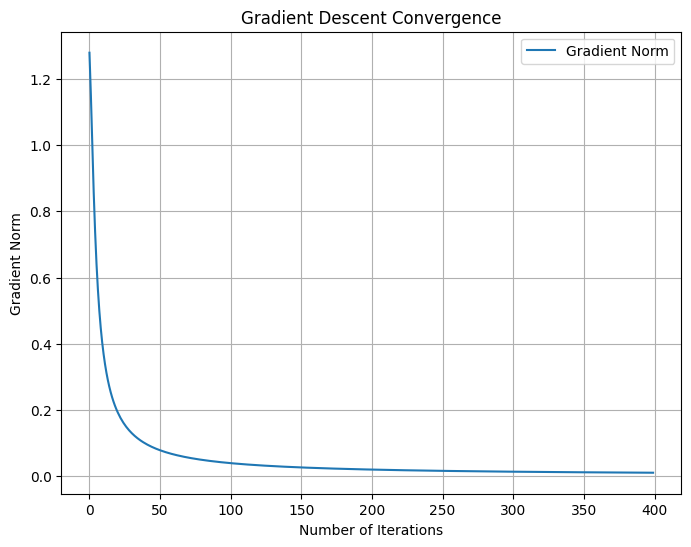

In [5]:
# QUESTION 3 : VISUALIZATION OF THE GRADIENT DESCENT (400 ITERATIONS)

gradient_values = gradient_descent(np.zeros(X_dense.shape[1]), X_dense, y, 400, 1e-6, 0.1)[1]

plt.figure(figsize=(8,6))
plt.plot(gradient_values, label="Gradient Norm")
plt.xlabel('Number of Iterations')
plt.ylabel('Gradient Norm')
plt.title('Gradient Descent Convergence')
plt.legend()
plt.grid()
plt.show()

In [6]:
# QUESTION 4 : CODING OF THE BATCH STOCHASTIC GRADIENT METHOD

import numpy as np
from scipy.sparse import csr_matrix

def batch_stochastic_gradient(x, A, y, iterations, seuil, param, batch_size):
    n = len(y)
    first_vector = x 
    gradient_values = [] 

    for i in range(iterations):
        batch_indices = np.random.choice(n, batch_size, replace=False)
        A_batch = A[batch_indices]
        y_batch = y[batch_indices]

        gradient = np.zeros_like(x)

        for indice in range(batch_size):
            a_i = A_batch[indice].toarray().flatten() if isinstance(A_batch[indice], csr_matrix) else A_batch[indice] 
            gradient += theoretical_gradient_f_i(first_vector, a_i, y_batch[indice])
        gradient = gradient / batch_size

        gradient_norm = np.linalg.norm(gradient)
        if gradient_norm < seuil:
            break

        gradient_values.append(gradient_norm)
        first_vector -= param*gradient

    return first_vector, gradient_values

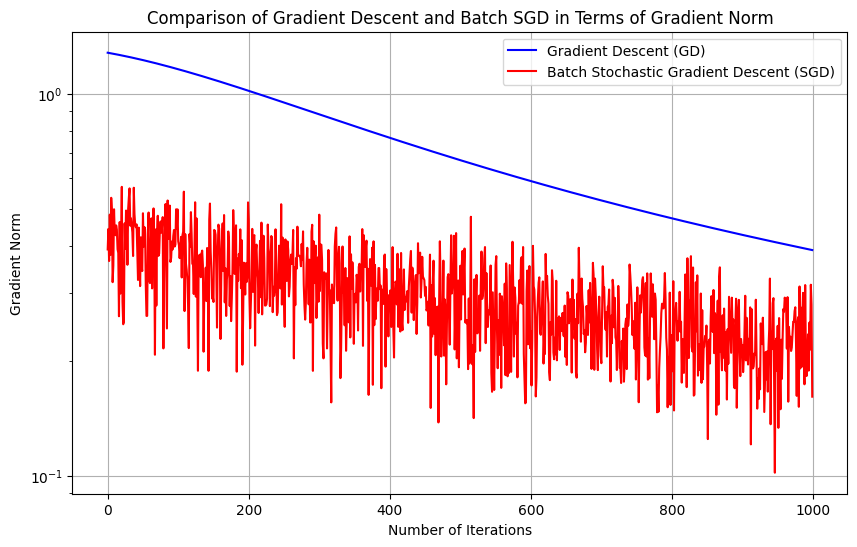

In [7]:
# QUESTION 4 : COMPARISON OF THE GRADIENT DESCENT AND THE BATCH STOCHASTIC GRADIENT DESCENT METHODS (VISUALIZATION). 

iterations = 1000
seuil = 1e-3
param = 0.001
batch_size = 32

x0 = np.zeros(X_dense.shape[1])  

# Run Gradient Descent (GD)
x_gd, gradient_norms_gd = gradient_descent(x0, X_dense, y, iterations, seuil, param)

# Run Batch Stochastic Gradient Descent (SGD)
x_sgd, gradient_norms_sgd = batch_stochastic_gradient(x0, X_dense, y, iterations, seuil, param, batch_size)

plt.figure(figsize=(10, 6))
plt.plot(gradient_norms_gd, label="Gradient Descent (GD)", color="blue")
plt.plot(gradient_norms_sgd, label="Batch Stochastic Gradient Descent (SGD)", color="red")

plt.xlabel("Number of Iterations")
plt.ylabel("Gradient Norm")
plt.title("Comparison of Gradient Descent and Batch SGD in Terms of Gradient Norm")
plt.legend()
plt.grid()
plt.yscale("log") # We see the convergence more precisely
plt.show()

QUESTION 4 : INTERPRETATION OF THE RESULTS 

IN THEORY, THE STOCHASTIC GRADIENT DESCENT CONVERGES FASTER THAN THE GRADIENT DECSENT WHEN IT COMES TO THE NUMBER OF ITERATIONS, WHICH IS SHOWN IN THE RESULTS ABOVE. HOWEVER, THE SGD METHOD IS MUCH MORE VOLATILE THAN THE GD METHOD AS WE CAN SEE THE RED LINE BEING REALLY UNSTABLE. WE ALSO HAVE TO CONSIDER THE FACT THAT I HAVE CHOSEN FAVORABLE PARAMETERS FOR THE SGD METHOD TO PLOT THIS FIGURE : BATCH SIZE = 32 AND STEPSIZE = 0.001. IT MAKES ITS GLOBAL PERFORMANCE A LITTLE BIT TARNISHED.
IN THE FOLLOWING QUESTION, I WILL HAVE TO COMPARE ADAGRAD WITH THE BEST METHOD BETWEEN THE TWO WE DISCUSSED. BECAUSE OF THE VISIBLE VOLATILITY OF THE BSG, I HAVE CHOSEN THE GRADIENT DESCENT AS THE BEST METHOD.

In [8]:
# QUESTION 5 : CODING OF THE ADAGRAD METHOD.

# I used this website to remind myself of the formulas and to code the function : https://optimization.cbe.cornell.edu/index.php?title=AdaGrad
# Here, the learning rate is 0.1 and epsilon=1e-6


import numpy as np
import matplotlib.pyplot as pyplot

def adagrad(x0, A, y, iterations, learning_rate, epsilon):
    n, d = A.shape
    x = x0.copy()  
    G = np.zeros(d)  # Squared gradients are initialized to 0 (vector)
    gradient_norms = []  

    for _ in range(iterations):
        gradient = gradient_f(x, A, y)
        gradient_norm = np.linalg.norm(gradient)
        gradient_norms.append(gradient_norm)
        G += gradient ** 2
        x -= (learning_rate / (np.sqrt(G) + epsilon)) * gradient

    return x, gradient_norms

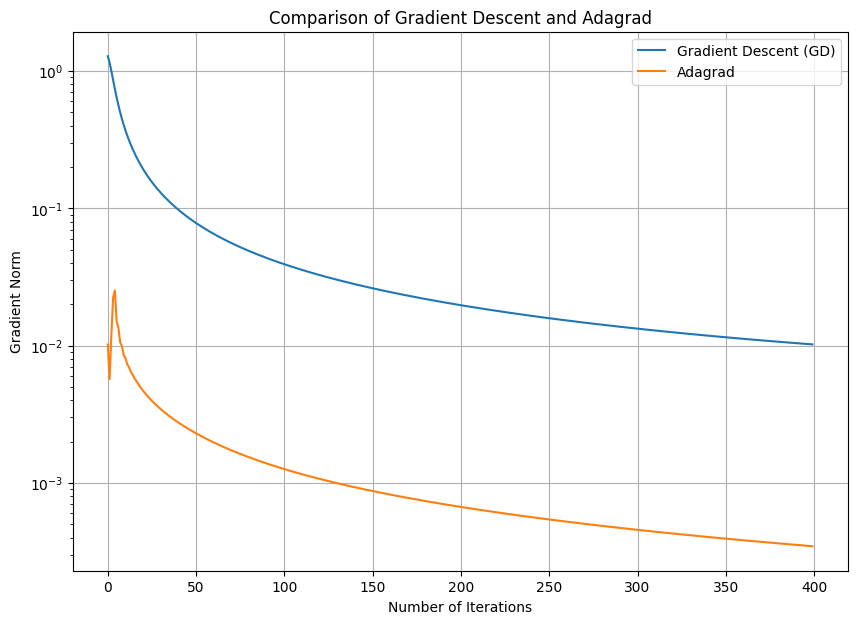

In [9]:
# QUESTION 5 : COMPARISON OF THE ADAGRAD AND THE GRADIENT DESCENT METHODS (VISUALIZATION).

x0 = np.zeros(X_dense.shape[1])  # Initial parameter vector
iterations = 400
learning_rate_gd = 0.1  
learning_rate_adagrad = 0.1  
epsilon = 1e-8
seuil = 1e-3

x_gd, gradient_norms_gd = gradient_descent(x0, X_dense, y, iterations, seuil, learning_rate_gd)
x_adagrad, gradient_norms_adagrad = adagrad(x0, X_dense, y, iterations, learning_rate_adagrad, epsilon)

plt.figure(figsize=(10, 7))
plt.plot(gradient_norms_gd, label="Gradient Descent (GD)")
plt.plot(gradient_norms_adagrad, label="Adagrad")
plt.xlabel("Number of Iterations")
plt.ylabel("Gradient Norm")
plt.title("Comparison of Gradient Descent and Adagrad")
plt.legend()
plt.grid()
plt.yscale("log")
plt.show()

QUESTION 5 : INTERPRETATION OF THE RESULTS

WE NOTICE THAT THE ADAGRAD CONVERGES FASTER THAN THE GRADIENT DESCENT METHOD BECAUSE ITS LEARNING RATE IS ADAPTATIVE COMPARED TO THE FIXED LEARNING RATE OF THE GRADIENT DESCENT (EVEN THOUGH HERE I HAVE PLOTTED WITH THE SAME FIXED LEARNING_RATE).
ONLINE DOCUMENTATION POINTS OUT THAT ADAGRAD MAY LEAD TO SLOW CONVERGENCES IN GREAT NUMBER OF ITERATIONS BC OF ITS AGRESSIVE LEARNING RATE DECAY BUT IT DOESN'T SEEM TO BE THE CASE HERE. (PLOTTING FOR MORE THAN 400 ITERATIONS TAKES TOO MUCH TIME)
TO CONCLUDE, THE ADAGRAD METHOD IS PREFERED TO THE GRADIENT DESCENT ONE.

In [10]:
# QUESTION 6 : CODING OF THE ADAGRAD PROXIMAL METHOD 

# For this section, I got help  from the formulas detailed in the 'Lasso Regularization' section 
# Of the 'Proximal gradient methods for learning' page in Wikipedia. 

import numpy as np

def compute_function_value(x, A, y, lambda_val=0):
    n = len(y)
    sigmoid = 1 / (1 + np.exp(-A @ x))  
    squared_error = np.mean((y - sigmoid) ** 2)  # Mean squared error term
    l1_penalty = lambda_val * np.sum(np.abs(x))  # L1 regularization term
    return squared_error + l1_penalty  

# Adaptation of the formulas 

def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)


# Formula : x(k+1) = S[ x(k) - gamma*grad_f(x(k)) ] where S_gamma(x) = prox_gamma_norm1(x) is defined just above

def adagrad_proximal(x0, A, y, iterations, lambda_val, learning_rate, epsilon):
    n, d = A.shape
    x = x0.copy()  
    G = np.zeros(d) 
    gradient_norms = []  


    for _ in range(iterations):
        gradient = gradient_f(x, A, y)
        gradient_norm = np.linalg.norm(gradient)
        gradient_norms.append(gradient_norm)

        G += gradient ** 2 
        x -= (learning_rate / (np.sqrt(G) + epsilon)) * gradient # Adagrad update
        x = soft_threshold(x, lambda_val * (learning_rate / (np.sqrt(G) + epsilon))) # Proximal operation for Lasso regularization

    return x, gradient_norms

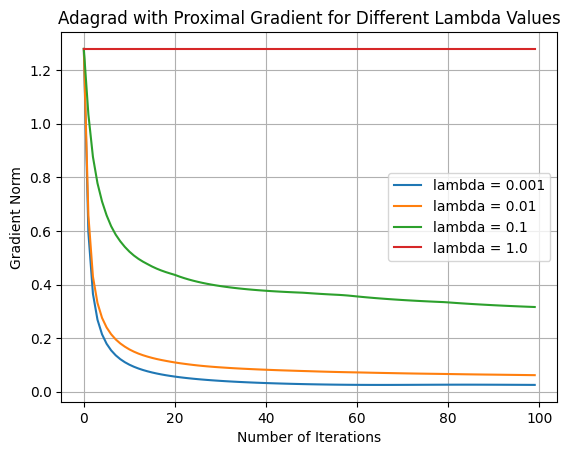

In [11]:
# QUESTION 6 : VISUALIZATION OF THE EFFECT OF ALPHA ON CONVERGENCE (FOR 100 ITERATIONS)


x0 = np.zeros(X_dense.shape[1])  
iterations = 100  
learning_rate = 0.1  # Learning rate for Adagrad
epsilon=1e-8
lambda_values = [0.001, 0.01, 0.1, 1.0]  


for lambda_val in lambda_values:
    x_opt, gradient_norms = adagrad_proximal(x0, X_dense, y, iterations, lambda_val, learning_rate, epsilon)
    sparsity = np.sum(np.abs(x_opt) > 1e-6)  # Help from ChatGPT for this line and the two next ones
    loss = compute_function_value(x_opt, X_dense, y)
    plt.plot(gradient_norms, label=f"lambda = {lambda_val}")


plt.xlabel("Number of Iterations")
plt.ylabel("Gradient Norm")
plt.title("Adagrad with Proximal Gradient for Different Lambda Values")
plt.legend()
plt.grid()
plt.show()

QUESTION 6 : DISCUSSIONS ABOUT THE CHOICE OF LAMBDA

THE CHOICE OF LAMBDA IS ABSOLUTELY CRUCIAL BECAUSE IT CONTROLS THE EFFECT OF REGULARIZATION ON THE FUNCTION. IT FAVORIZES SPARSE SOLUTIONS. HERE, BASED ON THE PLOT'S RESULTS, THE BETTER CHOICE OF LAMBDA SEEMS TO BE THE SMALLEST : 0.001 BECAUSE ITS RATE CONVERGENCE IS BETTER THAN WITH THE OTHER VALUES. 
NB : 1.0 IS A CATASTROPHIC CHOICE.

In [12]:
# QUESTION 7 : CODING OF THE BFGS METHOD

import numpy as np
import matplotlib.pyplot as plt

# Knowing the stepsize is changing, I got help from ChatGPT to determine the best one.
# The following function will be used at each step to determine the alpha(k).

def backtracking_line_search(x, p, grad, A, y, alpha=1, rho=0.5, c=1e-4):
    while compute_function_value(x + alpha * p, A, y) > compute_function_value(x, A, y) + c * alpha * np.dot(grad, p):
        alpha *= rho  # Reduce step size
    return alpha


# In the exact same way, this function will provide the H(k) matrix used in the recurrence relation at step k.
def bfgs_update(H, s, v):
    ps_s_v = np.dot(v, s)
    if ps_s_v > 1e-10:  # Instead of 0 for numerical stability 
        rho = 1.0 / ps_s_v
        I = np.eye(len(s))
        V = I - rho * np.outer(s, v) # outer bc vk(sk)T is a matrix
        H_new = V.T @ H @ V + rho * np.outer(s, s)
        return H_new
    return H  # If update is unstable, return previous H


# Gradient of f evaluated in x. y has a shape of (32561,)
def gradient_f(x, A, y):
    n = len(y)
    gradient = np.zeros_like(x)
    for a_i, y_i in zip(A, y):
        exp_term = np.exp(np.dot(a_i, x))
        numerator = -2 * exp_term * (exp_term * (y_i - 1) + y_i) * a_i
        denominator = (1 + exp_term) ** 3
        gradient += numerator / denominator
    return gradient / n    

# The following function will return the calculated optimizer and a list of gradient norms.
# It will help for the plottings and the convergence comparisons.

def bfgs_method(x, A, y, iterations, seuil):
    number_of_samples, number_of_features = A.shape
    x = x0
    H = np.eye(number_of_features)  
    gradient_norms = []  

    for i in range(iterations):
        gradient = gradient_f(x, A, y)
        gradient_norm = np.linalg.norm(gradient)
        gradient_norms.append(gradient_norm)  

        if gradient_norm < seuil:
            break

        descending_term = -H @ gradient
        alpha = backtracking_line_search(x, descending_term, gradient, A, y)

        # Quasi-Newton update of s(k) described between (5) and (6)
        s = alpha * descending_term 
        x_new = x + s # + because the - is included in s (hence the 'descending')

        # Quasi-Newton update of v(k) described between (5) and (6)
        new_gradient = gradient_f(x_new, A, y)
        v = new_gradient - gradient  # Gradient difference

        # Update of the Hessian matrix described in (6)
        H = bfgs_update(H, s, v)

        x = x_new

    return x, gradient_norms  

/var/folders/h3/l62xkv5n0nv0zw9dvcbq_gww0000gn/T/ipykernel_73094/1202451734.py:10: RuntimeWarning: overflow encountered in exp
  sigmoid = 1 / (1 + np.exp(-A @ x))


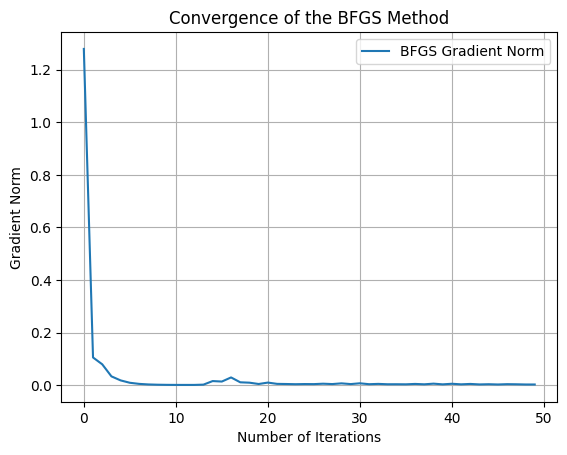

In [13]:
# QUESTION 7 : VISUALIZATION OF THE BFGS METHOD (50 ITERATIONS)

x0 = np.zeros(X_dense.shape[1])
x_opt, gradient_norms = bfgs_method(x0, X_dense, y, 50, 1e-6)

plt.plot(gradient_norms, label="BFGS Gradient Norm")
plt.xlabel("Number of Iterations")
plt.ylabel("Gradient Norm")
plt.title("Convergence of the BFGS Method")
plt.legend()
plt.grid()
plt.show()

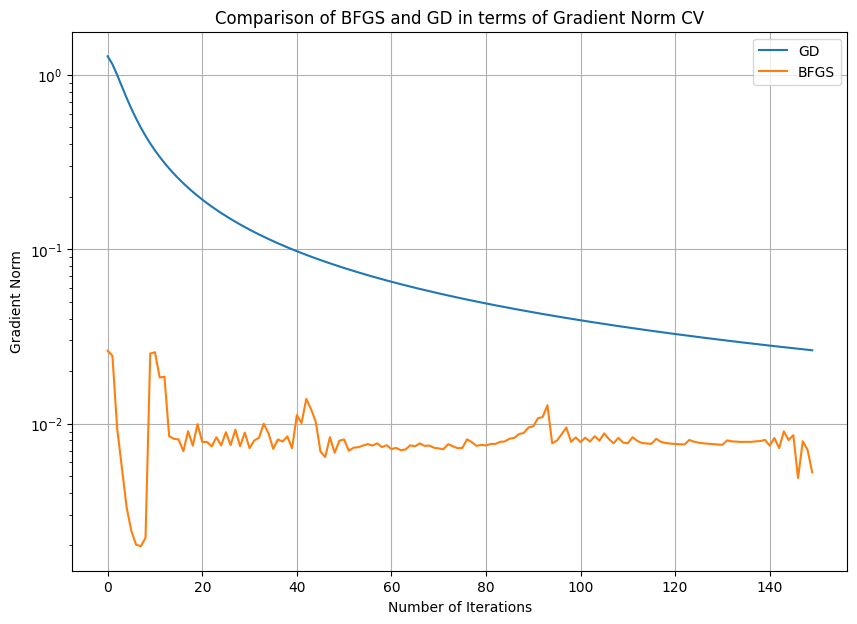

In [14]:
# QUESTION 7 : COMPARISON OF THE BFGS AND GD METHODS (150 ITERATIONS)

import matplotlib.pyplot as plt

A = X_dense
x0 = np.zeros(A.shape[1])
iterations = 150
seuil = 1e-6
param = 0.1  

x_gd, gradient_norms_gd = gradient_descent(x0, A, y, iterations, seuil, param) # GD
x_bfgs, gradient_norms_bfgs = bfgs_method(x0, A, y, iterations, seuil) # BFGS


plt.figure(figsize=(10,7))
plt.plot(gradient_norms_gd, label="GD")
plt.plot(gradient_norms_bfgs, label="BFGS")
plt.xlabel("Number of Iterations")
plt.ylabel("Gradient Norm")
plt.title("Comparison of BFGS and GD in terms of Gradient Norm CV")
plt.legend()
plt.grid()
plt.yscale("log")
plt.show()


QUESTION 7 : INTERPRETATION OF THE CONVERGENCE COMPARISON PLOT (BFGS VS GD)

BFGS CONVERGES FASTER THAN THE GD METHOD (AT 20 ITERATIONS, BFGS IS ALREADY BELOW 0.01 WHILE GD IS STILL GREATER THAN 0.1). IT IS BECAUSE THE BFGS APPROXIMATES THE HESSIAN MATRIX OF f, WHICH LEADS TO FASTER CONVERGENCE. HOWEVER, THE BFGS SEEMS SLIGHTLY MORE VOLATILE (ESPECIALLY IN THE VERY BEGINNING (<15 ITERATIONS) BUT IT IS MORE CONTROLLED AFTER). DESPITE THIS LITTLE TRADE-OFF, THE BFGS METHOD IS BETTER THAN THE GD FOR CONVERGENCE. 

In [15]:
# QUESTION 8 : CODING OF THE STOCHASTIC BFGS METHOD

# I added this version of the backtracking_line_search function bc I had dimension problems when I tried to run 
# the previous line_search function and I couldn't see figures when I tried to plot them.
# That's why this function is full ChatGPT.

def backtracking_line_search_1(f, x, p, grad, A_batch, y_batch, alpha=1, rho=0.5, c=1e-4):
    while f(x + alpha * p, A_batch, y_batch) > f(x, A_batch, y_batch) + c * alpha * np.dot(grad, p):
        alpha *= rho
    return alpha

# Let's define the stochastic BFGS method.

def stochastic_bfgs_method(x0, A, y, batch_size, iterations, seuil):

    batch_size = 20
    iterations = 100
    seuil = 0.001
    n, d = A.shape
    x = x0.copy()
    H = np.eye(d)
    gradient_norms = []
    
    for _ in range(iterations):
        batch_indices = np.random.choice(n, batch_size, replace=False)
        A_batch = A[batch_indices]
        y_batch = y[batch_indices]
        
        gradient = np.zeros_like(x)

        for indice in range(batch_size):
            a_i = A_batch[indice].toarray().flatten() if isinstance(A_batch[indice], csr_matrix) else A_batch[indice] 
            gradient += theoretical_gradient_f_i(x, a_i, y_batch[indice])
        gradient = gradient / batch_size
        
        # Gradient norm storage for the batch
        gradient_norm = np.linalg.norm(gradient)
        gradient_norms.append(gradient_norm)
        
        if gradient_norm < seuil:
            break
            
        decsending_term = -H.dot(gradient)
        alpha = backtracking_line_search_1(compute_function_value, x, decsending_term, gradient, A_batch, y_batch)
        
        s = alpha * decsending_term
        x_new = x + s
        
        gradient_new = np.zeros_like(x)
        for indice in range(batch_size):
            a_i = A_batch[indice].toarray().flatten() if isinstance(A_batch[indice], csr_matrix) else A_batch[indice]
            gradient_new += theoretical_gradient_f_i(x_new, a_i, y_batch[indice])
        gradient_new = gradient_new / batch_size
        
        v = gradient_new - gradient
        H = bfgs_update(H, s, v)
        
        x = x_new
        
    return x, gradient_norms

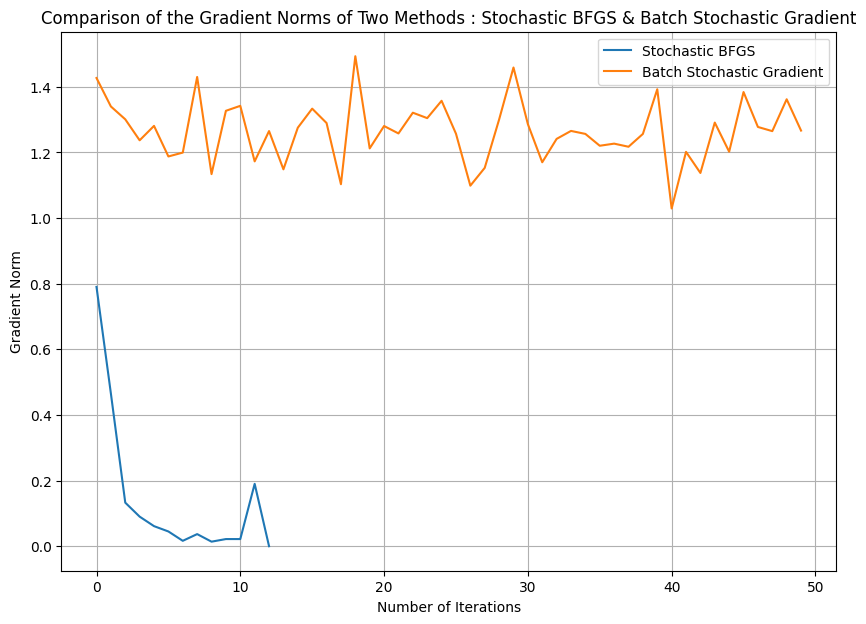

In [16]:
# QUESTION 8 : COMPARISON OF BFGS AND BATCH STOCHASTIC GRADIENT (VISUALIZATION)

import numpy as np
import matplotlib.pyplot as plt

x0 = np.zeros(X_dense.shape[1])
batch_size=100
iterations=50
seuil=0.001
param = 1e-3 # learning rate

# Comparison of BFGS and Batch Stochastic Gradient
gradient_norms_bfgs = stochastic_bfgs_method(x0, X_dense, y, batch_size, iterations, seuil)[1]
gradient_norms_bsg = batch_stochastic_gradient(x0, X_dense, y, iterations, seuil, param, batch_size)[1]


plt.figure(figsize=(10,7))
plt.plot(gradient_norms_bfgs, label="Stochastic BFGS")
plt.plot(gradient_norms_bsg, label="Batch Stochastic Gradient")
plt.xlabel('Number of Iterations')
plt.ylabel('Gradient Norm')
plt.title("Comparison of the Gradient Norms of Two Methods : Stochastic BFGS & Batch Stochastic Gradient")
plt.legend()
plt.grid()
plt.show()

QUESTION 8 : INTERPRETATION OF THE CONVERGENCE COMPARISON PLOT

WE NOTICE THAT THE STOCHASTIC BFGS PERFORMS MUCH MUCH BETTER THAN THE BATCH STOCHASTIC GRADIENT METHOD. AS CAN BE SEEN ON THE PLOT, THE STOCHASTIC BFGS CONVERGED TO A OPTIMUM X IN LESS THAN 15 ITERATIONS WHEREAS THE BATCH STOCHASTIC GRADIENT DOESN'T SEEM TO BE DECREASING EVEN AFTER 40 ITERATIONS. THIS MAY BE DUE TO MY BATCH SIZE CHOICE (100). I TRIED PLOTTING THE BATCH STOCHASTIC GRADIENT FOR GREATER ITERATIONS (200 AND 500) BUT NOTHING CHANGED IN TERMS OF CONVERGENCE QUALITY. 
MORE IMPORTANTLY, STOCHASTIC BFGS EXPLOITS SECOND-ORDER INFORMATION CONTRARY TO THE BATCH STOCHASTIC GRADIENT, WHICH LEADS TO FASTER CONVERGENCE.

IN CONCLUSION : BATCH STOCHASTIC GRADIENT << STOCHASTIC BFGS. 

QUESTION 9 : COMPARISON OF STOCHASTIC BFGS AND ADAGRAD

FOR AN ARBITRARY NUMBER OF ITERATIONS K, THE ADAGRAD METHOD LOOKS AT THE ENTIRE DATASET SO WHEN N IS THE DATASIZE (NUMBER OF SAMPLES), THE ADAGRAD METHOD ACCESSES K*N DATA POINTS. ON THE OTHER HAND, THE STOCHASTIC BFGS ACCESSES BATCH_SIZE POINTS AT EACH ITERATION. IN K ITERATIONS, IT ACCESSES K*BATCH_SIZE POINTS. IT IS MUCH SMALLER THAN K*N SO FOR THIS CRITERION, STOCHASTIC BFGS IS BETTER THAN ADAGRAD.

WHEN IT COMES TO THE NUMBER OF D-DIMENSIONAL VECTORS UPDATED AT EACH ITERATION, THE ADAGRAD METHOD IS BETTER THAN THE STOCHASTIC BFGS ONE. INDEED, ADAGRAD COMPUTES x, G AND g AT EACH ITERATION WHILE THE STOCHASTIC BFGS ACCESSES s, v, x AND alpha. 

In [17]:
# QUESTION 10 : CODING OF THE PROXIMAL GRADIENT METHOD IMPLEMENTED IN BFGS TECHNIQUES.

# Here, once we have updzted computed x(k+1) with H (BFGS), we apply proximal gradient to it.
# The 4 following functions have already been used in previous questions but they will help in the proximal BFGS method. 

import numpy as np

def compute_function_value(x, A, y):
    predictions = 1 / (1 + np.exp(-A @ x))  # Predicted probabilities
    loss = np.mean((y - predictions) ** 2)  # Mean squared error
    return loss

def backtracking_line_search(x, p, grad, A, y, alpha=1, rho=0.5, c=1e-4):
    # Backtracking line search to find a suitable step size
    # x is a current parameter vector of shape (d,) and p is a search direction of shape (d,)
    while compute_function_value(x + alpha * p, A, y) > compute_function_value(x, A, y) + c * alpha * np.dot(grad, p):
        alpha *= rho  
    return alpha

def bfgs_update(H, s, v):
    ps_s_v = np.dot(v, s)
    if ps_s_v > 1e-10:  
        rho = 1.0 / ps_s_v
        I = np.eye(len(s))
        V = I - rho * np.outer(s, v) 
        H_new = V.T @ H @ V + rho * np.outer(s, s)
        return H_new
    return H  

def gradient_f(x, A, y):
    n = len(y)
    gradient = np.zeros_like(x)
    for a_i, y_i in zip(A, y):
        exp_term = np.exp(np.dot(a_i, x))
        numerator = -2 * exp_term * (exp_term * (y_i - 1) + y_i) * a_i
        denominator = (1 + exp_term) ** 3
        gradient += numerator / denominator
    return gradient / n  

def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)


# PROXIMAL BFGS


def proximal_bfgs(x0, A, y, iterations, param, seuil):
    n, d = A.shape
    H = np.eye(d)
    x = x0.copy()
    epsilon = 1e-3
    gradient_norm_values = []

    for i in range(iterations):
        gradient = gradient_f(x, A, y)
        gradient_norm = np.linalg.norm(gradient)

        if gradient_norm < seuil:
            break

        gradient_norm_values.append(gradient_norm)

        scalar_product = -H @ gradient # Search direction (shape:(d,))
        alpha = backtracking_line_search(x, scalar_product, gradient, A, y) # ChatGPT

        # Quasi-Newton update
        descending_term = alpha*scalar_product
        intermediate_x = x + descending_term

        # Proximal gradient update
        threshold = param * alpha # Regularization parameter
        new_x = soft_threshold(intermediate_x, threshold)
        new_gradient = gradient_f(new_x, A, y)

        # Newton parameter updates
        s = new_x - x
        v = new_gradient - gradient
        H = bfgs_update(H, s, v)

        x = new_x

    return x, gradient_norm_values

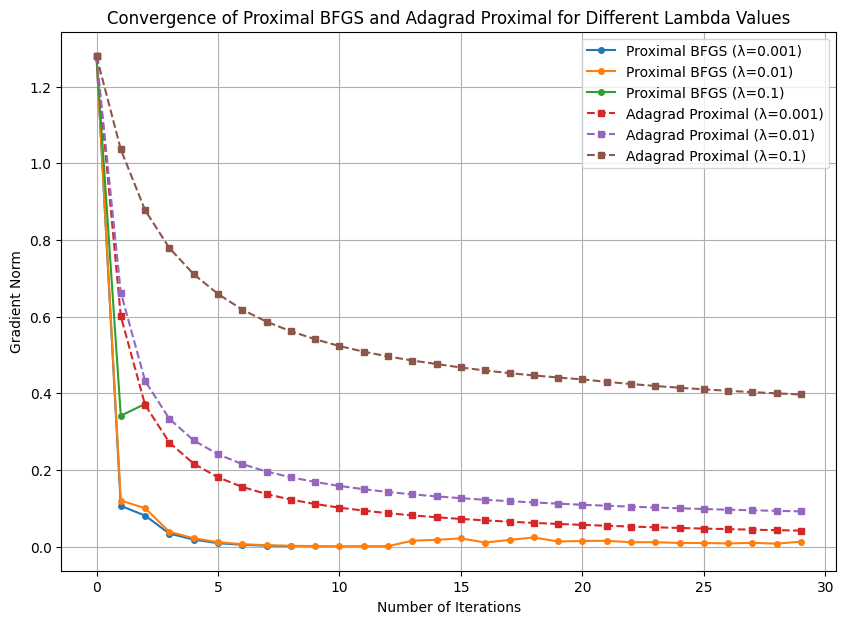

In [18]:
# QUESTION 10 : COMPARISON OF THE PROXIMAL BFGS AND ADAGRAD PROXIMAL FOR DIFFERENT VALUES OF LAMBDA (VISUALIZATION)

import numpy as np
import matplotlib.pyplot as plt

x0 = np.zeros(X_dense.shape[1]) 
iterations = 30 
param = 0.1  # Regularization parameter (lambda)
seuil = 1e-3  
lambda_values = [0.001, 0.01, 0.1]  

# I have to admit these are ChatGPT plot instructions. I didn't know how to plot three functions 
# simultaneously with different parameters.

bfgs_results = {}
adagrad_results = {}

for lambda_val in lambda_values:
    x_opt_bfgs_prox, grad_norm_bfgs = proximal_bfgs(x0, X_dense, y, iterations, lambda_val, seuil)
    x_opt_adagrad_prox, grad_norm_adagrad = adagrad_proximal(x0, X_dense, y, iterations, lambda_val, param, seuil)
    
    bfgs_results[lambda_val] = grad_norm_bfgs
    adagrad_results[lambda_val] = grad_norm_adagrad


plt.figure(figsize=(10, 7))


for lambda_val, grad_norms in bfgs_results.items():
    plt.plot(grad_norms, label=f"Proximal BFGS (λ={lambda_val})", linestyle='-', marker='o', markersize=4)


for lambda_val, grad_norms in adagrad_results.items():
    plt.plot(grad_norms, label=f"Adagrad Proximal (λ={lambda_val})", linestyle='--', marker='s', markersize=4)


plt.xlabel("Number of Iterations")
plt.ylabel("Gradient Norm")
plt.title("Convergence of Proximal BFGS and Adagrad Proximal for Different Lambda Values")
plt.legend()
plt.grid()
plt.show()

QUESTION 10 : INTERPRETATION OF THE PROXIMAL FBGS VS ADAGRAD PROXIMAL PLOT'S RESULTS.

THE CONVERGENCE SPEED OF PROXIMAL FBGS IS MUCH FASTER THAN THE ADAGRAD PROXIMAL CONVERGENCE SPEED BECAUSE ITS ACCESS TO SECOND-ORDER INFORMATION MAKES IT MORE PRECISE. MOREOVER, WE CAN SEE THAT THE CONVERGENCE RATE OF THE ADAGRAD PROXIMAL DECREASES OVER ITERATIONS. THIS MAY BE DUE TO ITS CHANGING LEARNING RATE. HOWEVER, THIS LEARNING RATE ENSURES THE SOLUTION TO BE SPARSE. 


In [19]:
# QUESTION 11 : CODING OF THE L-FBGS METHOD

# The following function will serve in the iteration k

def two_previous_loops(q_k, s_list, v_list):
   k = len(s_list)  # Number of stored vectors at iteration k
   m = len(s_list)  # Max memory size
   q = q_k.copy()
   gamma_list = []
   
   # First loop
   for l in range(1, min(k,m) + 1):
       if np.dot(s_list[-l], v_list[-l]) > 0:  # [-l] gives s[k-l] and v[k-l] bc s and v of size k
           gamma_l = np.dot(s_list[-l], q) / np.dot(v_list[-l], s_list[-l])
           gamma_list.append(gamma_l)
           q = q - gamma_l*v_list[-l]
   
   # Second loop
   for l in range(min(k,m), 0, -1):
       if np.dot(s_list[-l], v_list[-l]) > 0:
           delta = np.dot(v_list[-l], q) / np.dot(v_list[-l], s_list[-l])
           q += (gamma_list[l-1] - delta)*s_list[-l]
   
   return q


def l_bfgs(x0, A, y, m, iterations, seuil, learning_rate):
   x = x0.copy()
   s_list = []  # List of s_k vectors
   v_list = []  # List of v_k vectors
   gradient_norms = []
   
   for k in range(iterations):
       # Gradient of f evaluated in x[k]
       gradient_k = gradient_f(x, A, y)
       gradient_norm = np.linalg.norm(gradient_k)
       
       if gradient_norm < seuil:
           break
       
       gradient_norms.append(gradient_norm)

       # Search direction
       if k == 0:
           q_k = gradient_k
       else:
           q_k = two_previous_loops(gradient_k, s_list, v_list)
       
       # Line 15 of the algorithm
       x_new = x - learning_rate*q_k
    
       gradient_new = gradient_f(x_new, A, y)
       s_k = x_new - x
       v_k = gradient_new - gradient_k
       
       # Memory_update
       if np.dot(s_k, v_k) > 0:
           if len(s_list) == m:  # I had an empty list issue when I tried to plot so that's why I added this command
               s_list.pop(0)     # Remove oldest s
               v_list.pop(0)     # Remove oldest v
           s_list.append(s_k)
           v_list.append(v_k)
       
       x = x_new
   
   return x, gradient_norms

QUESTION 11 : FAILED ATTEMPT TO PLOT CONVERGENCE RESULTS FOR L-FBGS.

I'M HAVING TROUBLES TO SOLVE THIS ISSUE WITH EMPTY LISTS, EVEN THOUGH I AM MAKING SURE I POP NON EMPTY LIST (SEE COMMAND IN THE CODE JUST AFTER # MEMORY UPDATE). CONSEQUENTLY, I CAN'T COMPARE THIS METHOD WITH THE BFGS ONE AND DO THE QUESTION 12.